# Create input new scenarios based on ctsm 5.2 updated dataset for texture and soil carbon

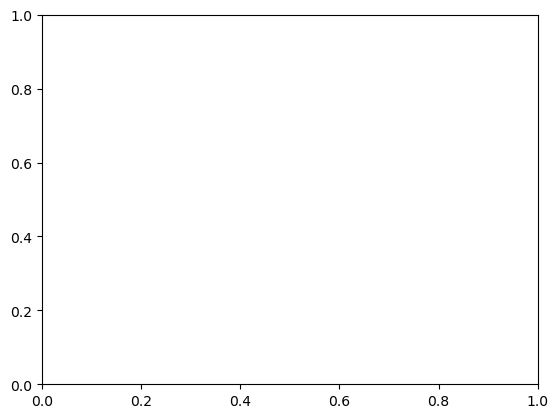

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from ctsm_py.utils import *
import numpy as np
from iv_utils_daint import *

import regionmask 
set_plot_param()

## Load  updated inputdata

See https://github.com/ESCOMP/CTSM/issues/1303

Copied from there:


Technically, this should just be calculated on the fine earth fraction (1-coarse fragments).

the WISE lookup table has all of this information

| Property |	units |	long_name |
| -------- | -------- | --------- | 
| ORGC |	gC kg^-1 soil	| organic carbon content |
| BULK |	g soil cm^-3	| bulk density |
| CFRAG|	volumetric, %	| coarse fragment |

ORGANIC = ORGC * BULK * (100-CFRAG)/100  * 1/0.58 

use a prescribed value of 130 kg OM/m3 as the maximum organic matter
density, based on standard density of peat soils 

In [2]:
# directory settings

#inputdir = '/scratch/snx3000/ivanderk/CCLM2_inputdata/cesm_inputdata/CTSM_hcru_inputdata/'

outdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/'
figdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/4p1000/figures/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 
inputdir = procdir+'CTSM_hcru_inputdata/'

filename_ctsm52 = 'surfdata_360x720cru_hist_78pfts_CMIP6_2000_c230510.nc'

filename_clm5 = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
ds_input_ctsm52 = xr.open_dataset(inputdir+filename_ctsm52)

In [3]:
landmask = ds_input_ctsm52['LANDFRAC_PFT']>0

da_orgc    = ds_input_ctsm52['ORGC']
da_bulk    = ds_input_ctsm52['BULK']
da_cfrag   = ds_input_ctsm52['CFRAG']
da_organic = ds_input_ctsm52['ORGANIC']

da_pct_clay    = ds_input_ctsm52['PCT_CLAY']
da_pct_sand    = ds_input_ctsm52['PCT_SAND']

# for analysis
da_pct_crop = ds_input_ctsm52['PCT_CROP']


### Plotting purpose settings

In [4]:
# for plotting purposes

# import case that has been run for longitude and latitude

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
# I2000Clm51Sp.hcru_hcru_mt13.4p1000_CTL_pft.20230712-1723
case = case_ctl
block = "lnd"
stream = "h0"

variables = ["watsat", "H2OSOI" ]

start_year = 2004
end_year = 2004

time_slice = slice(str(start_year) + "-01-01", str(end_year) + "-12-01")

ds = import_case(case_ctl, myVars=variables, timeSlice=time_slice,  alter_lons=False)

# hydrologically active soil layers (constraint by varying bedrock depths) all in meters

# middle of soil layer: layer node depth (zi)
levsoi = ds['levsoi'].values

# tickness at soil layer - delta zi - from CLM user's guide Table 2.3 
levsoi_thickness = [0.02,0.04,0.6,0.8,0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4,0.44,0.54,0.64,0.74,0.84,0.94,1.04,1.14]

# depth at soil layer zh,i  - from CLM user's guide Table 2.3 
levsoi_depth     = [0.02,0.06,0.12,0.2,0.32,0.48,0.68,0.92,1.2,1.52,1.88,2.28,2.72,3.26,3.9,4.64,5.48,6.42,7.46,8.6]


# all soil layers (deepest 5 layers are for thermodynamical calculations)
levgrnd = ds['levgrnd'].values

# tickness at soil layer - delta zi - from CLM user's guide Table 2.3 
levgrnd_thickness = [0.02,0.04,0.6,0.8,0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4,0.44,0.54,0.64,0.74,0.84,0.94,1.04,1.14,2.39,4.676,7.635,11.14,15.115]

# depth at soil layer zh,i  - from CLM user's guide Table 2.3 
levgrnd_depth = [0.02,0.06,0.12,0.2,0.32,0.48,0.68,0.92,1.2,1.52,1.88,2.28,2.72,3.26,3.9,4.64,5.48,6.42,7.46,8.6,10.99,15.666,23.301,34.441,49.556]



## Option 1: Relative increase in SOC using same method as Zomer et al 2017 based on CLM WISE data
see [./notebooks_4p1000/scenario_design.ipynb](/notebooks_4p1000/scenario_design.ipynb) for elaborate description

### 0. Double check calculation of CLM ORGANIC based on SOC, bulk and coarse fragment fraction provided in CLM

From https://github.com/ESCOMP/CTSM/issues/1303#issuecomment-1103295279

```
ORGANIC = ORGC*BULK*(100-CFRAG)/100  *1/0.58 
```

In [14]:
da_organic_recalculated = da_orgc*da_bulk*(100-da_cfrag)/100  *1/0.58 
da_organic_recalculated.attrs = da_organic.attrs



MemoryError: Unable to allocate 501. GiB for an array with shape (360, 720, 360, 720) and data type float64

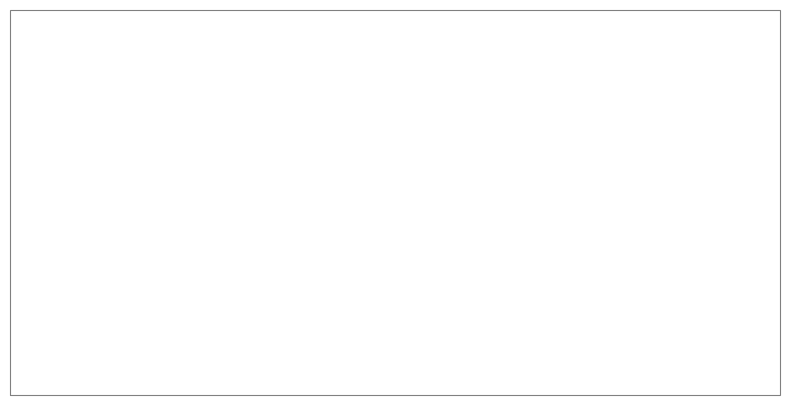

In [15]:
da_toplot =  da_organic
cmap='Oranges'
landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
# limiting values for plotting are given    
da_toplot.weighted(da_toplot['nlevsoi']).mean(dim='nlevsoi').where(landmask).plot(ax=ax, cmap=cmap, vmax=130, cbar_kwargs={'label': ' ('+da_toplot.units+')', 'fraction': 0.02, 'pad': 0.04})
ax.set_title(' ', loc='center')
ax.set_title(da_toplot.long_name+ ' ('+da_toplot.units+')', loc='right');
ax.coastlines(color='dimgray', linewidth=0.5)
# exclude Antactica from plot
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')

(-180.0, 180.0, -63.0, 90.0)

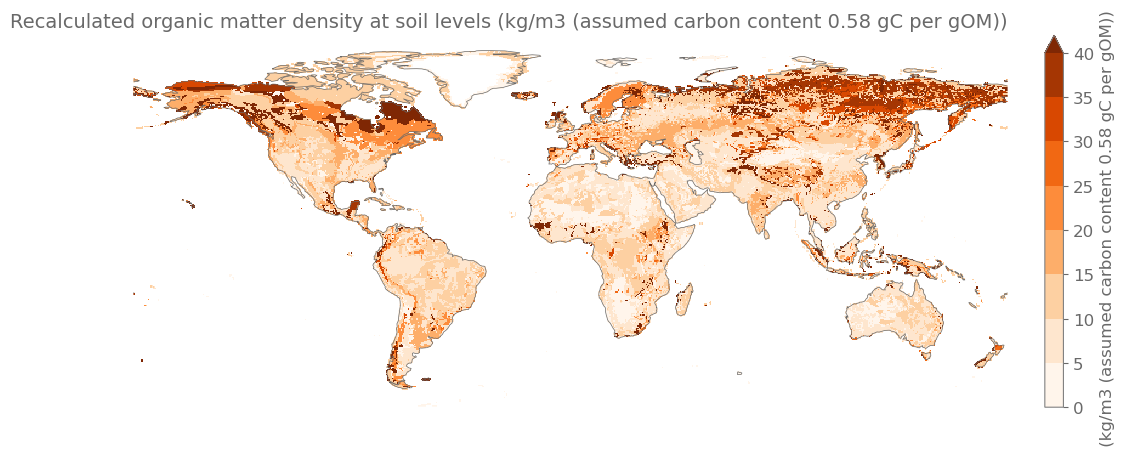

In [18]:
da_toplot =  da_organic_recalculated.assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})

landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
# limiting values for plotting are given   
levels = [0,5,10,15,20,25,30,35,40]
da_toplot.weighted(da_toplot['nlevsoi']).mean(dim='nlevsoi').where(landmask).plot(ax=ax, cmap=cmap, vmax=130, cbar_kwargs={'label': ' ('+da_toplot.units+')', 'fraction': 0.02, 'pad': 0.04}, levels = levels)
ax.set_title(' ', loc='center')
ax.set_title('Recalculated '+da_toplot.long_name+ ' ('+da_toplot.units+')', loc='right');
ax.coastlines(color='dimgray', linewidth=0.5)
# exclude Antactica from plot
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')

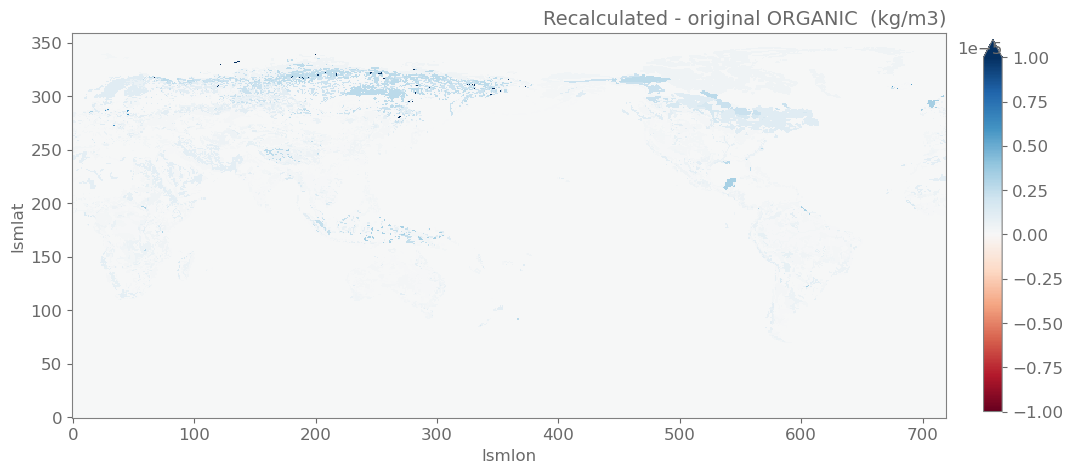

In [19]:
da_toplot = (da_organic_recalculated - da_organic)

cmap = 'RdBu'
proj=ccrs.PlateCarree()

plt.figure(figsize=(12,5))
ax = plt.subplot(111)
da_toplot.weighted(da_toplot['nlevsoi']).mean(dim='nlevsoi').plot(ax=ax, vmax=1e-5,vmin=-1e-5, cmap=cmap, cbar_kwargs={'label': '', 'fraction': 0.02, 'pad': 0.04})
ax.set_title('Recalculated - original ORGANIC  (kg/m3)', loc='right');

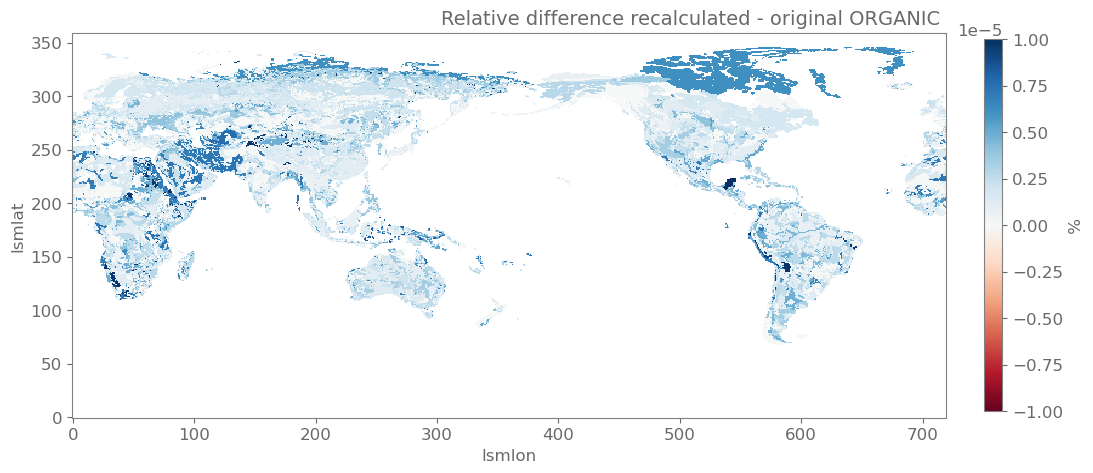

In [20]:
da_toplot = ((da_organic_recalculated - da_organic )/da_organic) *100

cmap = 'RdBu'
proj=ccrs.PlateCarree()

plt.figure(figsize=(12,5))
ax = plt.subplot(111)
da_toplot.weighted(da_toplot['nlevsoi']).mean(dim='nlevsoi').plot(ax=ax, vmax=1e-5, vmin=-1e-5, cmap=cmap, cbar_kwargs={'label': ' % ', 'fraction': 0.02, 'pad': 0.04})
ax.set_title('Relative difference recalculated - original ORGANIC ', loc='right');

Differences in calculated ORGANIC and provided organic are small: save to calculate in postprocessing

Deviations possibly due to aggregating in mapping tool. Not necessary for using surface map creation! 

### 1. Calculate total SOC after 20 years (add percent increase after 20 years based on Sommer and Bosio 2014 scenarios)

Take ORGC provided as variable in CLM

In [5]:
# Increase in soil organic carbon (% increase after 20 years)
soc_pctincr_20y = {}

# from Zomer et al. 2017 - CHECK UNITS
soc_pctincr_20y['medium'] = 0.27 # %
soc_pctincr_20y['high'] = 0.55 # %
soc_pctincr_20y['4p1000'] = 8 # % (0.4 %/year * 20 years)
#soc_pctincr_20y['8p1000'] = 16 # % (0.4 %/year * 20 years)

scenarios = list(soc_pctincr_20y.keys())
scenarios_and_CTL =  scenarios+['CTL']


In [6]:
# get long names of scenarios (for plotting)

scenarios_longnames = []
d_scenarios_longnames = {}

for scenario, value in zip(scenarios, list(soc_pctincr_20y.values())): 
    
    if scenario == '4p1000': 
        scenario_name = scenario + ' ('+str(value)+' % of current SOC)'

    else: 
        scenario_name = scenario + ' (+'+str(value)+' % SOC)'
    scenarios_longnames.append(scenario_name)
    d_scenarios_longnames[scenario] = scenario_name

In [7]:
# Calculate new SOC data
d_orgc_20y = {}

# add soil level coordinates (to be able to subset) and convert from gC/kg to kg/kg and then to %
da_orgc_pct = da_orgc.assign_coords(nlevsoi=np.arange(0,10)) * 0.1

for scenario in scenarios: 
    print(scenario)
    print(soc_pctincr_20y[scenario])


    # select only for 5 first soil layers ( fifth soil layer goes until 0.32m depth)
    da_orgc_upper30cm = da_orgc_pct.sel(nlevsoi=slice(0,4))
    da_orgc_below30cm = da_orgc_pct.sel(nlevsoi=slice(5,len(da_orgc.nlevsoi)))


    # calculate SOC after 20 years following scenario
    if scenario == '4p1000' or scenario=='8p1000': 
        
        # accumulation rate based on current stocks
        da_orgc_20y_upper30cm_new  = da_orgc_upper30cm + da_orgc_upper30cm * soc_pctincr_20y[scenario]/100

    else: # addition of percent SOC
        
        da_orgc_20y_upper30cm_new  = (da_orgc_upper30cm + float(soc_pctincr_20y[scenario])).where(da_orgc_upper30cm>=0)


    # merge upper increased 30 cms and original below 30 cm soil levels and convert from % to gC/kg
    da_orgc_20y = xr.concat([da_orgc_20y_upper30cm_new, da_orgc_below30cm], dim='nlevsoi') * 10

    # save per scenario in dictionary
    d_orgc_20y[scenario] = da_orgc_20y
    

medium
0.27
high
0.55
4p1000
8


In [10]:
d_orgc_20y["high"].sel(nlevsoi=range(0,5))

<xarray.DataArray 'ORGC' (nlevsoi: 5, lsmlat: 360, lsmlon: 720)>
array([[[5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        ...,
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5]],

       [[5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        ...,
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5]],

       [[5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        ...,
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5]],

       [[5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        ...,
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5]],

       [[5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        ...,
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5],
        [5.5, 5.5, 5.5, ..., 5.5, 5.5, 5.5]]], dtype=float32)
Coordinates:
  * nlevsoi  (nlevsoi) int64 0 1 2 3 4
Dimensions without coordinates: lsmlat, lsmlon

### Plot the differences

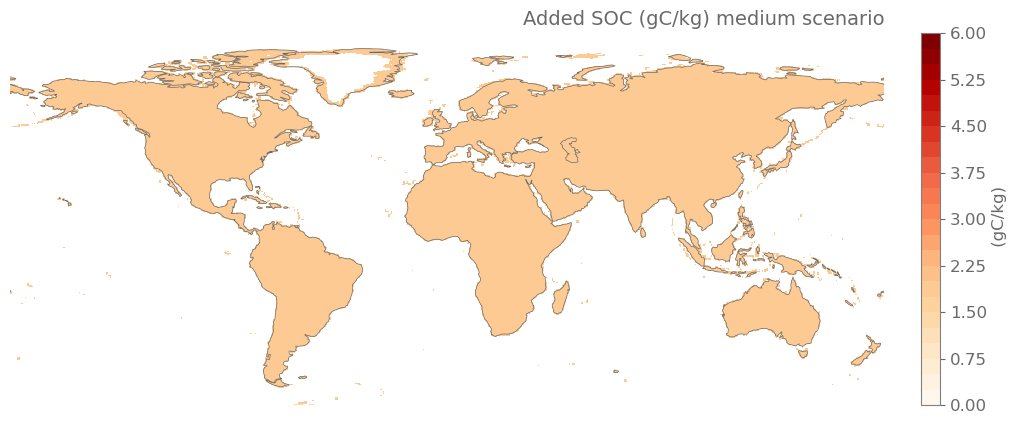

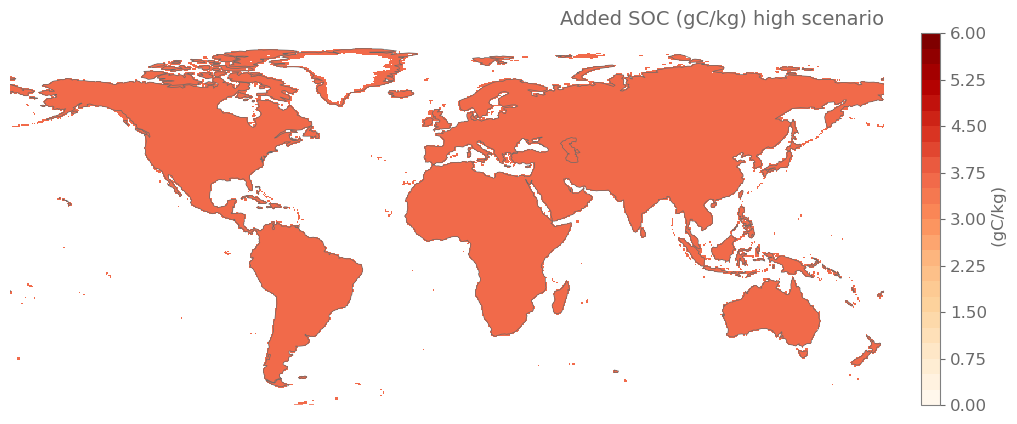

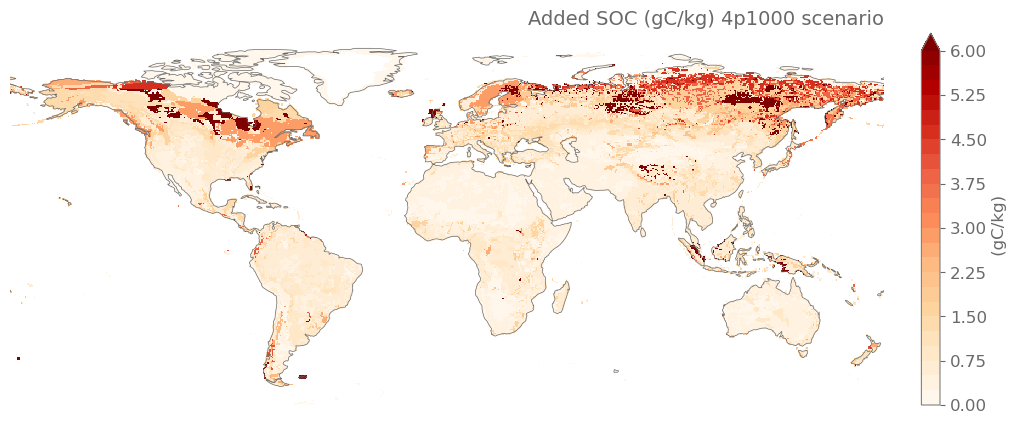

In [24]:
for scenario in scenarios: 
    da_toplot = (d_orgc_20y[scenario]-da_orgc.assign_coords(nlevsoi=np.arange(0,10))).assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})
    landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

    plt.figure(figsize=(12,5))
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj)
    levels = np.arange(0,6.25,0.25)
    #da_toplot[0,:,:].plot(ax=ax, cmap='OrRd',cbar_kwargs={'label': ' ()', 'fraction': 0.02, 'pad': 0.04}) #, levels = levels)
    da_toplot.sel(nlevsoi=slice(0,5)).weighted(da_toplot['nlevsoi']).mean(dim='nlevsoi').where(landmask).plot(ax=ax, cmap='OrRd', levels=levels, cbar_kwargs={'label': ' (gC/kg)', 'fraction': 0.02, 'pad': 0.04}) #, levels = levels)
    ax.set_title(' ', loc='center')
    ax.set_title('Added SOC (gC/kg) '+scenario+ ' scenario', loc='right');
    ax.coastlines(color='dimgray', linewidth=0.5)
    # exclude Antactica from plot
    ax.set_extent((-180,180,-63,90), crs=proj) 
    ax.axis('off')

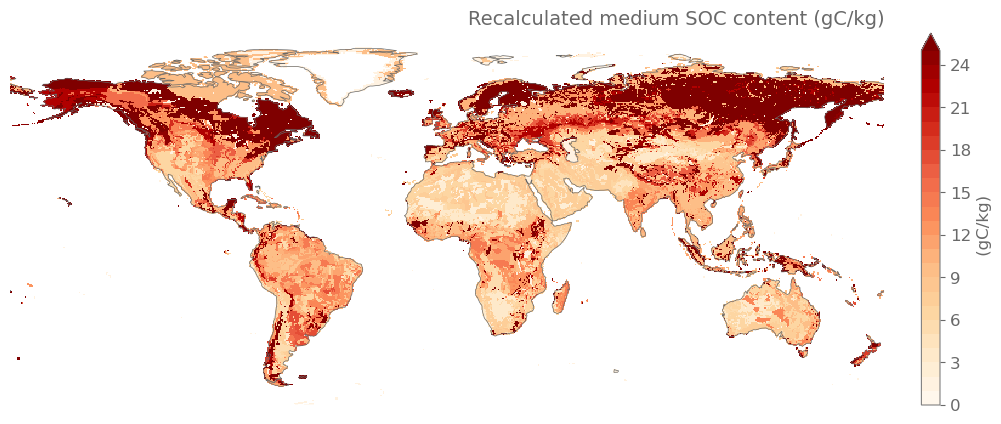

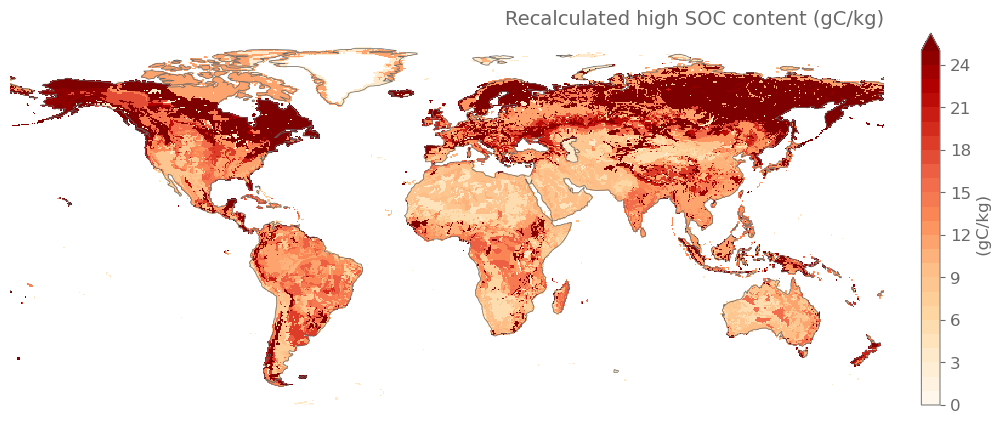

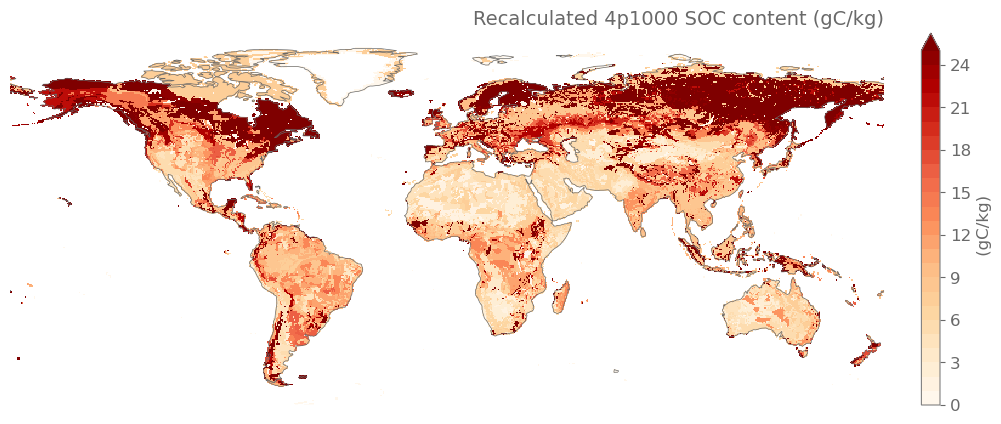

In [25]:
for scenario in scenarios: 
    da_toplot = (d_orgc_20y[scenario]).assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})
    landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

    plt.figure(figsize=(12,5))
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj)
    levels = np.arange(0,26,1)
    #da_toplot[0,:,:].plot(ax=ax, cmap='OrRd',cbar_kwargs={'label': ' ()', 'fraction': 0.02, 'pad': 0.04}) #, levels = levels)
    da_toplot.sel(nlevsoi=slice(0,5)).weighted(da_toplot['nlevsoi']).mean(dim='nlevsoi').where(landmask).plot(ax=ax, cmap='OrRd', levels=levels, cbar_kwargs={'label': ' (gC/kg)', 'fraction': 0.02, 'pad': 0.04}) #, levels = levels)
    ax.set_title(' ', loc='center')
    ax.set_title('Recalculated '+scenario+ ' SOC content (gC/kg)', loc='right');
    ax.coastlines(color='dimgray', linewidth=0.5)
    # exclude Antactica from plot
    ax.set_extent((-180,180,-63,90), crs=proj) 
    ax.axis('off')

### Save new CLM input file for the different scenarios

In [26]:
inputdir_4p1000 = '/scratch/snx3000/ivanderk/processing_4p1000/surfdata_4p1000/'

# only need to be done once
print('cp '+inputdir+filename_clm5+' '+inputdir_4p1000+filename_clm5[:-3]+'_copy.nc')

# save pct clay and sand in seperate nc file
ds_pct_clay = da_pct_clay.to_dataset(name='PCT_CLAY')
ds_pct_clay.to_netcdf(inputdir_4p1000+filename_clm5[:-3]+'_pct_clay.nc')

ds_pct_sand = da_pct_sand.to_dataset(name='PCT_SAND')
ds_pct_sand.to_netcdf(inputdir_4p1000+filename_clm5[:-3]+'_pct_sand.nc')


# REPLACE percent clay in new dataset
print('ncks -x -v PCT_CLAY '+inputdir_4p1000+filename_clm5[:-3]+'_copy.nc'+' '+inputdir_4p1000+filename_clm5[:-3]+'_no_pct_clay.nc')
print()
print('ncks -A '+inputdir_4p1000+filename_clm5[:-3]+'_pct_clay.nc' + ' '+ inputdir_4p1000+filename_clm5[:-3]+'_no_pct_clay.nc')
print()
print('mv '+inputdir_4p1000+filename_clm5[:-3]+'_no_pct_clay.nc'+' '+ inputdir_4p1000+filename_clm5[:-3]+'_updated_clay.nc')
print()
print('rm '+ inputdir_4p1000+filename_clm5[:-3]+'_pct_clay.nc')

#sand
print('ncks -x -v PCT_SAND '+inputdir_4p1000+filename_clm5[:-3]+'_updated_clay.nc'+' '+inputdir_4p1000+filename_clm5[:-3]+'_no_pct_sand.nc')
print()
print('ncks -A '+inputdir_4p1000+filename_clm5[:-3]+'_pct_sand.nc' + ' '+ inputdir_4p1000+filename_clm5[:-3]+'_no_pct_sand.nc')
print()
print('mv '+inputdir_4p1000+filename_clm5[:-3]+'_no_pct_sand.nc'+' '+ inputdir_4p1000+filename_clm5[:-3]+'_updated_sand_clay.nc')
print()
print('rm '+ inputdir_4p1000+filename_clm5[:-3]+'_updated_clay.nc')
print('rm '+ inputdir_4p1000+filename_clm5[:-3]+'_pct_sand.nc')



cp /dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/processing_4p1000/CTSM_hcru_inputdata/surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824.nc /scratch/snx3000/ivanderk/processing_4p1000/surfdata_4p1000/surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_copy.nc


PermissionError: [Errno 13] Permission denied: b'/scratch/snx3000/ivanderk/processing_4p1000/surfdata_4p1000/surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_pct_clay.nc'

In [ ]:


# REPLACE ORGANIC in new dataset
d_organic_20y = {}

d_organic_20y['CTL'] = da_orgc*da_bulk*(100-da_cfrag)/100  *1/0.58 

for scenario in scenarios: 
    d_organic_20y[scenario] = d_orgc_20y[scenario] * da_bulk*(100-da_cfrag)/100  *1/0.58 

    
    
# for the different scenarios and control


for scenario in scenarios_and_CTL[0:3]: 
    
    # convert to organic first!
    
    # save organic
    ds_organic_tosave = d_organic_20y[scenario].to_dataset(name='ORGANIC')

    filename_organic_4p = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_organic_'+scenario+'.nc'
    ds_organic_tosave.to_netcdf(inputdir_4p1000+filename_organic_4p)

    # generate code to run in terminal. 
    print()
    print('ncks -x -v ORGANIC '+inputdir_4p1000+filename_clm5[:-3]+'_updated_sand_clay.nc'+' '+inputdir_4p1000+filename_clm5[:-3]+'_no_organic.nc')
    print()
    print('ncks -A '+inputdir_4p1000+filename_clm5[:-3]+'_organic_'+scenario+'.nc' + ' '+ inputdir_4p1000+filename_clm5[:-3]+'_no_organic.nc')
    print()
    print('mv '+inputdir_4p1000+filename_clm5[:-3]+'_no_organic.nc'+' '+ inputdir_4p1000+filename_clm5[:-3]+'_'+scenario+'.nc')
    print()
    print('rm '+inputdir_4p1000+filename_organic_4p)  

#### 1.2 Check results: plot profiles of new data

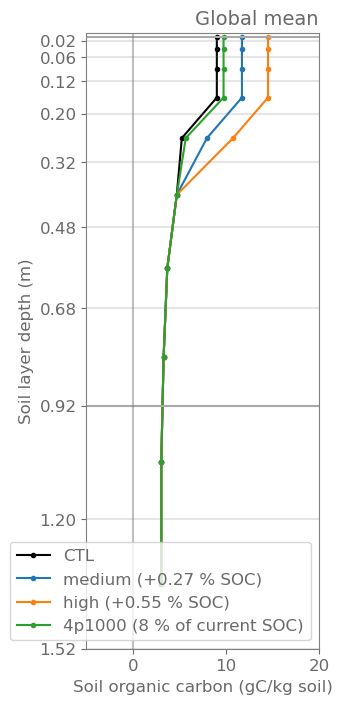

In [27]:
xlims=[-5,20]

fig, ax = plt.subplots(1,1,figsize=(3,8))
    
da_orgc_toplot =  da_orgc.assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})
da_region = da_orgc_toplot.mean(dim=('lat','lon'))

ax.plot(da_region, levsoi[:10], marker='.', color='black')


for scenario in scenarios: 

    da_orgc_20y_toplot = d_orgc_20y[scenario].assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})
    da_region_new =  da_orgc_20y_toplot.mean(dim=('lat','lon'))

    ax.plot(da_region_new, levsoi[:10], marker='.', alpha=1)


ax.legend(['CTL']+scenarios_longnames, loc='lower right')

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic carbon (gC/kg soil)'); 

ax.hlines(levsoi_depth, xlims[0],xlims[1], color='grey', alpha=0.2, label='z$_{i,h}$')
ax.hlines(levsoi_depth[7],xlims[0],xlims[1], color='darkgrey', alpha=1)
ax.hlines(0.01, xlims[0],xlims[1], color='darkgrey', alpha=1)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)

ax.set_xlim([xlims[0],xlims[1]])
ax.set_yticks(levsoi_depth)

ax.set_title('Global mean', loc='right' );
ax.set_ylim([max(levsoi_depth[:10]),0]); 

NameError: name 'd_organic_20y' is not defined

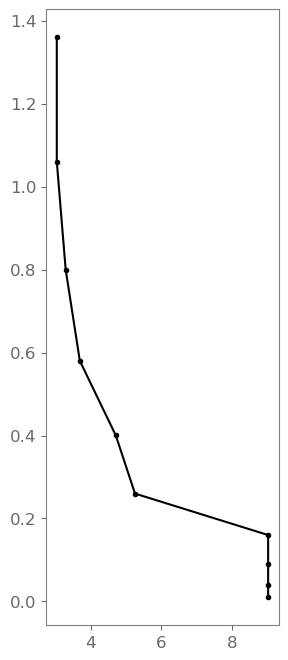

In [28]:
xlims=[-5,30]

fig, ax = plt.subplots(1,1,figsize=(3,8))
    
da_orgc_toplot =  da_orgc.assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})
da_region = da_orgc_toplot.mean(dim=('lat','lon'))

ax.plot(da_region, levsoi[:10], marker='.', color='black')


for scenario in scenarios: 

    da_orgc_20y_toplot = d_organic_20y[scenario].assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})
    da_region_new =  da_orgc_20y_toplot.mean(dim=('lat','lon'))

    ax.plot(da_region_new, levsoi[:10], marker='.', alpha=1)


ax.legend(['CTL']+scenarios_longnames, loc='lower right')

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic Material (g OM/m3 soil)'); 

ax.hlines(levsoi_depth, xlims[0],xlims[1], color='grey', alpha=0.2, label='z$_{i,h}$')
ax.hlines(levsoi_depth[7],xlims[0],xlims[1], color='darkgrey', alpha=1)
ax.hlines(0.01, xlims[0],xlims[1], color='darkgrey', alpha=1)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)

ax.set_xlim([xlims[0],xlims[1]])
ax.set_yticks(levsoi_depth)

ax.set_title('Global mean', loc='right' );
ax.set_ylim([max(levsoi_depth[:10]),0]); 

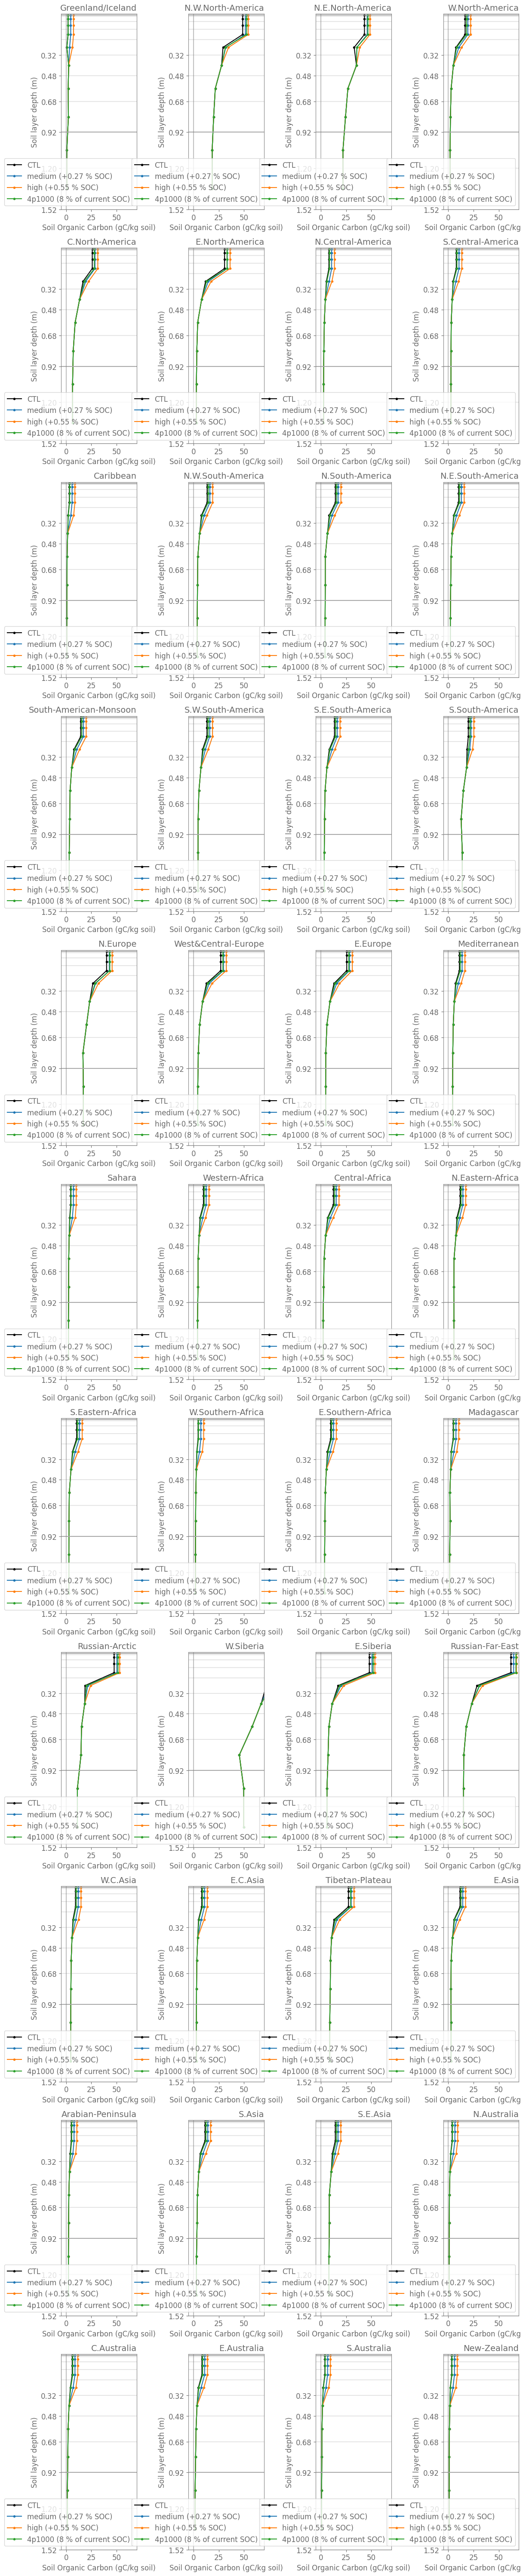

In [17]:
xlims=[-5,70]

mask = regionmask.defined_regions.ar6.land.mask(ds['watsat'])

region_ids = np.arange(0,44)
fig, axes = plt.subplots(11,4,figsize=(12,60))
axes = axes.flatten()

da_orgc_toplot =  da_orgc.assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})

d_orgc_20y_toplot = {}

for scenario in scenarios: 
    d_orgc_20y_toplot[scenario] = d_orgc_20y[scenario].assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat', 'nlevsoi':'levsoi'})

layers = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
for i,region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    da_region = da_orgc_toplot.where(mask==region).mean(dim=('lat','lon'))
    ax.plot(da_region, levsoi[:10], marker='.', color='black')

    for scenario in scenarios: 
        da_region_new =  d_orgc_20y_toplot[scenario].where(mask==region).mean(dim=('lat','lon'))

        ax.plot(da_region_new, levsoi[:10], marker='.')
    

    ax.legend(['CTL']+scenarios_longnames, loc='lower right')

    ax.set_ylabel('Soil layer depth (m)'); 
    ax.set_xlabel('Soil Organic Carbon (gC/kg soil)'); 

    ax.hlines(levsoi_depth, xlims[0],xlims[1], color='grey', alpha=0.2, label='z$_{i,h}$')
    ax.hlines(levsoi_depth[7],xlims[0],xlims[1], color='darkgrey', alpha=1)
    ax.hlines(0.01, xlims[0],xlims[1], color='darkgrey', alpha=1)
    ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)

    ax.set_xlim([xlims[0],xlims[1]])
    ax.set_yticks(levsoi_depth[4:])

    ax.set_title(region_name, loc='right' );
    ax.set_ylim([max(levsoi_depth[:10]),0]); 
    
fig.tight_layout()

#### 1.3 Check results: calculate and compare carbon totals

In [3]:
## Base organic carbon

# calculate SOC in % (gC/kg soil) = 0.1 * [%]
da_orgc_pct = (da_orgc*0.1)[0,:,:]

da_toplot =  da_orgc_pct.assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})
landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
# limiting values for plotting are given    
da_toplot.where(landmask).plot(ax=ax, cmap='Oranges', vmax=3, cbar_kwargs={'label': ' SOC %', 'fraction': 0.02, 'pad': 0.04})
ax.set_title(' ', loc='center')
ax.set_title('Percent Soil Organic Carbon (kg C/kg soil)*100 (compare to Padarian et al. Fig 3.)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
# exclude Antactica from plot
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')

NameError: name 'da_orgc' is not defined

(-180.0, 180.0, -63.0, 90.0)

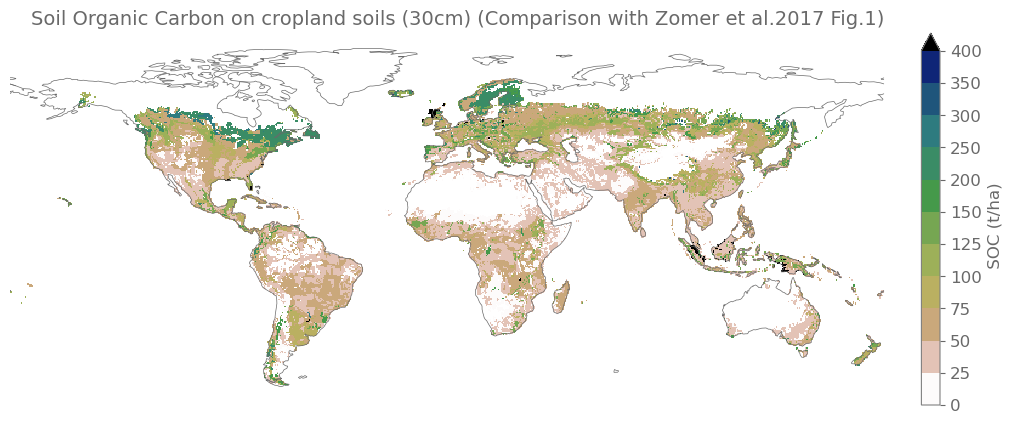

In [16]:
# calculate SOC  in t/ha
da_orgc_t_per_ha = (0.1 * da_orgc * da_bulk).sel(nlevsoi=slice(0,5)).mean(dim='nlevsoi')*30


da_toplot =  da_orgc_t_per_ha.where(da_pct_crop).assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})
landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
# limiting values for plotting are given    
levels = [0,25,50,75,100,125,150,200,250,300,350,400]
da_toplot.where(landmask).plot(ax=ax, cmap='gist_earth_r', cbar_kwargs={'label': ' SOC (t/ha)', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Soil Organic Carbon on cropland soils (30cm) (Comparison with Zomer et al.2017 Fig.1)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
# exclude Antactica from plot
ax.set_extent((-180,180,-63,90), crs=proj) 
ax.axis('off')

In [29]:
# weigh %SOC based on PCT crop
print('CLM input data')
mean_org_pct_croplands = da_orgc_pct.weighted(da_pct_crop).mean().values
print('mean topsoil (30cm) percent SOC in cropland soils: '+str(np.round(mean_org_pct_croplands,2)) +' %')
mean_org_t_per_ha_croplands  = da_orgc_t_per_ha.weighted(da_pct_crop).mean().values
print('mean topsoil (30cm) SOC in cropland soils: '+str(np.round(mean_org_t_per_ha_croplands,2)) +' t/ha')
print()
print('Values from Padarian et al. 2022')
print('mean topsoil (30cm) percent SOC in cropland soils: 1.37 %')
print('mean topsoil (30cm) SOC in cropland soils: 59.1 t/ha')
print()
print('Values from Zomer et al. 2017 (table 1)')
print('mean topsoil (30cm) SOC in cropland soils: 82 t/ha')

CLM input data
mean topsoil (30cm) percent SOC in cropland soils: 1.22 %
mean topsoil (30cm) SOC in cropland soils: 68.04 t/ha

Values from Padarian et al. 2022
mean topsoil (30cm) percent SOC in cropland soils: 1.37 %
mean topsoil (30cm) SOC in cropland soils: 59.1 t/ha

Values from Zomer et al. 2017 (table 1)
mean topsoil (30cm) SOC in cropland soils: 82 t/ha


In [30]:
# calculate total SOC using cropland area from Zomer et al. 
total_SOC_PgC = (mean_org_t_per_ha_croplands * 100 * 15935304)/1e9 # PgC

print('Total SOC in cropland soils using cropland area from Zomer et al. 2017: '+str(np.round(total_SOC_PgC,2)) +' PgC')

print()
print('Reported value in Zomer et al., 2017 (table 1) : 131.81 PgC')


Total SOC in cropland soils using cropland area from Zomer et al. 2017: 108.42 PgC

Reported value in Zomer et al., 2017 (table 1) : 131.81 PgC


# Unit conversion
units: from gC/kg soil to t/ha

```
ORGC * BULK* depth * 0.1 = ORGC_t_ha

[gC/kg] * [g/cm3] * [cm] * 0.1 = [t/ha]
```



In [ ]:
d_orgc_increase_tperha = {}
d_orgc_20y_tperha = {}
depth = 30 #cm
for scenario in scenarios:

    orgc_increase = d_orgc_20y[scenario] - da_orgc
    
    # convert units from gC/kg to t/ha
    d_orgc_increase_tperha[scenario] = (orgc_increase[0:5,:,:] * da_bulk[0:5,:,:] * 0.1).mean(dim='nlevsoi') * depth 
    d_orgc_20y_tperha[scenario] = (d_orgc_20y[scenario][0:5,:,:] * da_bulk[0:5,:,:] * 0.1).mean(dim='nlevsoi') * depth 



In [ ]:
landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

for scenario in scenarios: 
    da_increase_toplot =  d_orgc_increase_tperha[scenario].where(da_pct_crop).assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})

    plt.figure(figsize=(12,5))
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj)
    # limiting values for plotting are given   
    levels = np.arange(0,1.3,0.1)

    (da_increase_toplot/20).where(landmask).plot(ax=ax, cmap='YlOrBr', levels=levels, cbar_kwargs={'label': ' (tC / (ha year)', 'ticks':levels, 'fraction': 0.02, 'pad': 0.04}, vmax=1.5)
    ax.set_title(' ', loc='center')
    ax.set_title('Annual increase of soil organic carbon in cropland soils (30 cm) \n '+d_scenarios_longnames[scenario]+' scenario', loc='right')
    ax.coastlines(color='dimgray', linewidth=0.5)
    # exclude Antactica from plot
    ax.set_extent((-180,180,-63,90), crs=proj) 
    ax.axis('off')

In [ ]:
d_orgc_increase_tperha[scenario]

"The 4p1000 Initiative has identified an aspirational sequestration target of 3.5 Pg C/yr to provide substantive global mitigation. Our estimates suggest that from 26% up to 53% (0.90–1.85 Pg C) of this target could be reached in the top 30 cm of cropland soils alone, and continue over at least 20 years after adoption of SOC enhancing management, such as incorporation of organic manures, cover cropping, mulching, conservation tillage, some types for agroforestry practices, rotational grazing, or other practices known to increase soil carbon at the decadal scale."

In [ ]:
# cropland area from Zomer et al. 2017 (compare to Table 1)
cropland_area = 15935304 # km2

print('Global average SOC in croplands')
for scenario in scenarios: 
    global_average_soc_t_ha = d_orgc_20y_tperha[scenario].weighted(da_pct_crop).mean(dim=('lsmlat','lsmlon'))
    print(scenario +': '+str(np.round(global_average_soc_t_ha.values,2)) +' tC/ha')
print('')
print('')

print('Global average annual increase SOC in croplands')
for scenario in scenarios: 
    global_average_soc_t_ha = (d_orgc_increase_tperha[scenario]/20).weighted(da_pct_crop).mean(dim=('lsmlat','lsmlon'))
    print(scenario +': '+str(np.round(global_average_soc_t_ha.values,2)) +' tC/ha year')   

print(' ')
print(' ')
print('Global Total SOC on croplands')

for scenario in scenarios: 
    global_average_soc_t_ha = (d_orgc_20y_tperha[scenario].weighted(da_pct_crop).mean(dim=('lsmlat','lsmlon')) * cropland_area/100 )/1e5
    print(scenario +': '+str(np.round(global_average_soc_t_ha.values,2)) +' PgC')

    
    

## For analysis/comparison: load cropland fraction of gridcells

In [ ]:
landmask = (ds['watsat']>=0)[0,0,:,:].squeeze()

da_increase_toplot =  da_pct_crop.assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})

plt.figure(figsize=(12,5))
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
# limiting values for plotting are given    
levels = np.concatenate([np.array([0,1]),(np.arange(10,100,10))])
da_increase_toplot.where(landmask).plot(ax=ax, cmap='gist_earth_r', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Percent crop of gridcell', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)

# exclude Antactica from plot
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off')